In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
#from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
#from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [5]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:10<00:00, 18.63it/s]


In [6]:
print(len(lrv_test))

200


In [7]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
healthy_train_label = np.full(len(healthy_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
healthy_test_label = np.full(len(healthy_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
virus_test_label = np.full(len(virus_test),6)

In [8]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, healthy_train, insect_train, lrv_train, virus_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, healthy_train_label, insect_train_label, lrv_train_label, virus_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, healthy_test, insect_test, lrv_test,  virus_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, healthy_test_label, insect_test_label, lrv_test_label, virus_test_label), axis = 0)

In [9]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [10]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [12]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [13]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

ras      = ResNet50(include_top=False, input_shape=input_shape)(inputs)
dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(ras), GlobalAveragePooling2D()(dennet), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_1[0][0]']             
                                                          4                                       
                                                                                            

In [16]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/resDenseVgg16(7_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [17]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
137/136 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.7492

136/136 [==============================] - 334s 2s/step - loss: 0.6934 - accuracy: 0.7492 - val_loss: 0.2188 - val_accuracy: 0.9305 - lr: 1.0000e-04
Epoch 2/50
137/136 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8780

136/136 [==============================] - 203s 1s/step - loss: 0.3149 - accuracy: 0.8780 - val_loss: 0.0720 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 3/50
137/136 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.8954

136/136 [==============================] - 195s 1s/step - loss: 0.2766 - accuracy: 0.8954 - val_loss: 0.0994 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 4/50
137/136 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.8943

136/136 [==============================] - 203s 1s/step - loss: 0.2590 - accuracy: 0.8943 - val_loss: 0.0528 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 5/50
137/136 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.8966

136/136 [==============================] - 203s 1s/step - loss: 0.2465 - accuracy: 0.8966 - val_loss: 0.0803 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 6/50
137/136 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9146

136/136 [==============================] - 198s 1s/step - loss: 0.2198 - accuracy: 0.9146 - val_loss: 0.0508 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 7/50
137/136 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9140

136/136 [==============================] - 206s 2s/step - loss: 0.2065 - accuracy: 0.9140 - val_loss: 0.0581 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 8/50
137/136 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9236

136/136 [==============================] - 203s 1s/step - loss: 0.1958 - accuracy: 0.9236 - val_loss: 0.0539 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 9/50
137/136 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9215

136/136 [==============================] - 197s 1s/step - loss: 0.1911 - accuracy: 0.9215 - val_loss: 0.0643 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 10/50
137/136 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9261

136/136 [==============================] - 205s 1s/step - loss: 0.2009 - accuracy: 0.9261 - val_loss: 0.1853 - val_accuracy: 0.9350 - lr: 1.0000e-04
Epoch 11/50
137/136 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9291

136/136 [==============================] - 203s 1s/step - loss: 0.1833 - accuracy: 0.9291 - val_loss: 0.0819 - val_accuracy: 0.9680 - lr: 1.0000e-04
Epoch 12/50
137/136 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9318

136/136 [==============================] - 203s 1s/step - loss: 0.1733 - accuracy: 0.9318 - val_loss: 0.0610 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 13/50
137/136 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9330

136/136 [==============================] - 195s 1s/step - loss: 0.1717 - accuracy: 0.9330 - val_loss: 0.0296 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 14/50
137/136 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9211

136/136 [==============================] - 204s 1s/step - loss: 0.1838 - accuracy: 0.9211 - val_loss: 0.0455 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 15/50
137/136 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9327

136/136 [==============================] - 203s 1s/step - loss: 0.1718 - accuracy: 0.9327 - val_loss: 0.0627 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 16/50
137/136 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9396

136/136 [==============================] - 203s 1s/step - loss: 0.1610 - accuracy: 0.9396 - val_loss: 0.0665 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 17/50
137/136 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9410

136/136 [==============================] - 204s 1s/step - loss: 0.1467 - accuracy: 0.9410 - val_loss: 0.0773 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 18/50
137/136 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9352

136/136 [==============================] - 204s 1s/step - loss: 0.1647 - accuracy: 0.9352 - val_loss: 0.0667 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 19/50
137/136 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9368

136/136 [==============================] - 204s 1s/step - loss: 0.1523 - accuracy: 0.9368 - val_loss: 0.0522 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 20/50
137/136 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9371

136/136 [==============================] - 203s 1s/step - loss: 0.1561 - accuracy: 0.9371 - val_loss: 0.0328 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 21/50
137/136 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9483

136/136 [==============================] - 203s 1s/step - loss: 0.1345 - accuracy: 0.9483 - val_loss: 0.0611 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 22/50
137/136 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9407

136/136 [==============================] - 195s 1s/step - loss: 0.1488 - accuracy: 0.9407 - val_loss: 0.0374 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 23/50
137/136 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9355

136/136 [==============================] - 195s 1s/step - loss: 0.1617 - accuracy: 0.9355 - val_loss: 0.1164 - val_accuracy: 0.9661 - lr: 1.0000e-04
Epoch 24/50
137/136 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9430

136/136 [==============================] - 203s 1s/step - loss: 0.1361 - accuracy: 0.9430 - val_loss: 0.0316 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 25/50
137/136 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9460

136/136 [==============================] - 195s 1s/step - loss: 0.1353 - accuracy: 0.9460 - val_loss: 0.0611 - val_accuracy: 0.9735 - lr: 1.0000e-04
Epoch 26/50
137/136 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9410

136/136 [==============================] - 203s 1s/step - loss: 0.1526 - accuracy: 0.9410 - val_loss: 0.0442 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 27/50
137/136 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9432

136/136 [==============================] - 205s 1s/step - loss: 0.1435 - accuracy: 0.9432 - val_loss: 0.0809 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 28/50
137/136 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9465

136/136 [==============================] - 197s 1s/step - loss: 0.1434 - accuracy: 0.9465 - val_loss: 0.0183 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 29/50
137/136 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9506

136/136 [==============================] - 203s 1s/step - loss: 0.1336 - accuracy: 0.9506 - val_loss: 0.0760 - val_accuracy: 0.9726 - lr: 1.0000e-04
Epoch 30/50
137/136 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9494

136/136 [==============================] - 195s 1s/step - loss: 0.1351 - accuracy: 0.9494 - val_loss: 0.0333 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 31/50
137/136 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9428

136/136 [==============================] - 203s 1s/step - loss: 0.1412 - accuracy: 0.9428 - val_loss: 0.0297 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 32/50
137/136 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9483

136/136 [==============================] - 204s 1s/step - loss: 0.1274 - accuracy: 0.9483 - val_loss: 0.0187 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 33/50
137/136 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.9435

136/136 [==============================] - 202s 1s/step - loss: 0.1365 - accuracy: 0.9435 - val_loss: 0.0580 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 34/50
137/136 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9487

136/136 [==============================] - 203s 1s/step - loss: 0.1262 - accuracy: 0.9487 - val_loss: 0.0187 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 35/50
137/136 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9449

136/136 [==============================] - 195s 1s/step - loss: 0.1326 - accuracy: 0.9449 - val_loss: 0.0287 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 36/50
137/136 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9476

136/136 [==============================] - 203s 1s/step - loss: 0.1357 - accuracy: 0.9476 - val_loss: 0.0322 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 37/50
137/136 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9483

136/136 [==============================] - 202s 1s/step - loss: 0.1253 - accuracy: 0.9483 - val_loss: 0.0254 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 38/50
137/136 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9522

136/136 [==============================] - 203s 1s/step - loss: 0.1208 - accuracy: 0.9522 - val_loss: 0.1064 - val_accuracy: 0.9616 - lr: 1.0000e-04
Epoch 39/50
137/136 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9513

136/136 [==============================] - 196s 1s/step - loss: 0.1264 - accuracy: 0.9513 - val_loss: 0.0183 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 40/50
137/136 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9574

136/136 [==============================] - 204s 1s/step - loss: 0.1105 - accuracy: 0.9574 - val_loss: 0.0291 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 41/50
137/136 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9524

136/136 [==============================] - 203s 1s/step - loss: 0.1214 - accuracy: 0.9524 - val_loss: 0.0131 - val_accuracy: 0.9963 - lr: 1.0000e-04
Epoch 42/50
137/136 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9497

136/136 [==============================] - 204s 1s/step - loss: 0.1287 - accuracy: 0.9497 - val_loss: 0.0786 - val_accuracy: 0.9780 - lr: 1.0000e-04
Epoch 43/50
137/136 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9503

136/136 [==============================] - 203s 1s/step - loss: 0.1267 - accuracy: 0.9503 - val_loss: 0.0154 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 44/50
137/136 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.9524

136/136 [==============================] - 204s 1s/step - loss: 0.1241 - accuracy: 0.9524 - val_loss: 0.0210 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 45/50
137/136 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9568

136/136 [==============================] - 206s 2s/step - loss: 0.1145 - accuracy: 0.9568 - val_loss: 0.0673 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 46/50
137/136 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.9584

136/136 [==============================] - 203s 1s/step - loss: 0.1095 - accuracy: 0.9584 - val_loss: 0.1330 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 47/50
137/136 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9554

136/136 [==============================] - 194s 1s/step - loss: 0.1115 - accuracy: 0.9554 - val_loss: 0.0367 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 48/50
137/136 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9531

136/136 [==============================] - 203s 1s/step - loss: 0.1222 - accuracy: 0.9531 - val_loss: 0.0292 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 49/50
137/136 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9568

136/136 [==============================] - 203s 1s/step - loss: 0.1149 - accuracy: 0.9568 - val_loss: 0.0218 - val_accuracy: 0.9918 - lr: 1.0000e-04
Epoch 50/50
137/136 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9584

136/136 [==============================] - 202s 1s/step - loss: 0.1168 - accuracy: 0.9584 - val_loss: 0.0203 - val_accuracy: 0.9927 - lr: 1.0000e-04


47/47 [==============================] - 35s 625ms/step
Confusion matrix, without normalization
[[202   0   0   4   0   0   0]
 [  0 274   4   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  0   0   0 205   0   0   0]
 [  0   0   0   0 198   4   4]
 [  0   0   0   0   4 196   0]
 [  0   0   0   0   1   0 199]]


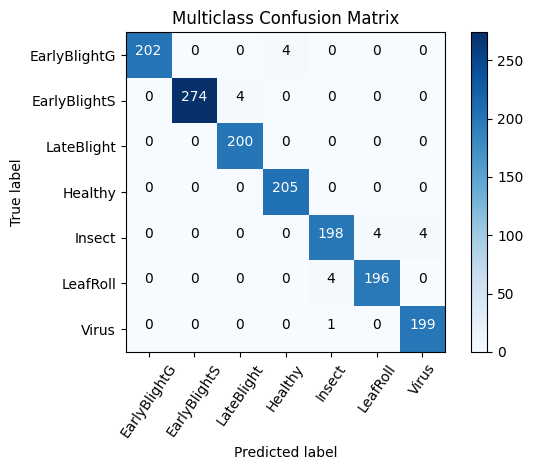

In [18]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

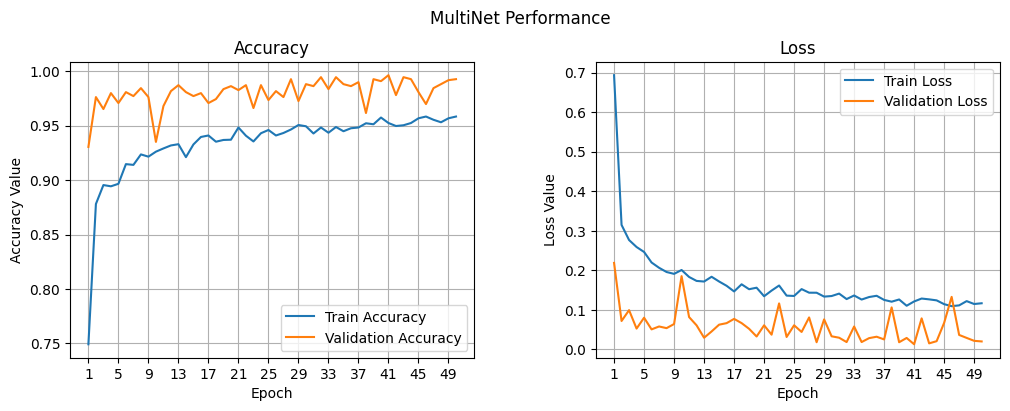

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [20]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 17s 359ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       1.00      0.98      0.99       206
EarlyBlight Serious       1.00      0.99      0.99       278
         LateBlight       0.98      1.00      0.99       200
            Healthy       0.98      1.00      0.99       205
             Insect       0.98      0.96      0.97       206
           LeafRoll       0.98      0.98      0.98       200
              Virus       0.98      0.99      0.99       200

           accuracy                           0.99      1495
          macro avg       0.99      0.99      0.99      1495
       weighted avg       0.99      0.99      0.99      1495



In [21]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("MultiNet(ResNet50,DenseNet201,VGG16)")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 17s 363ms/step
MultiNet(ResNet50,DenseNet201,VGG16)
Accuracy: 0.9859531772575251
F1 Score: 0.9859692587189581
precision: 0.9861115242234889
recall: 0.9859531772575251
MSE: 0.04548494983277592
MAE: 0.02274247491638796


In [22]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

47/47 [==============================] - 17s 355ms/step


In [23]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc

0.36911196911196914

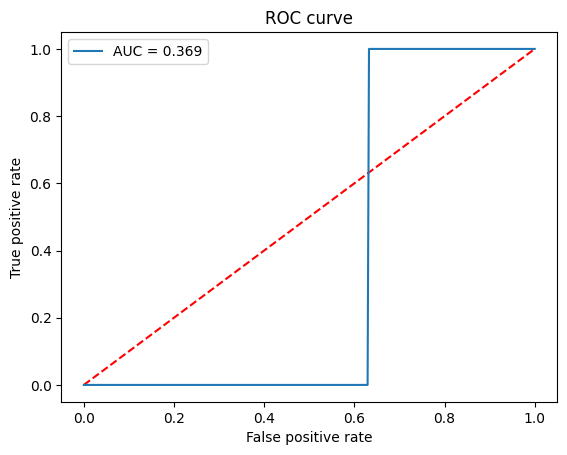

In [24]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
